In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import ndimage as ndi
from PIL import Image
from skimage import feature
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray

0.0031073446327683617


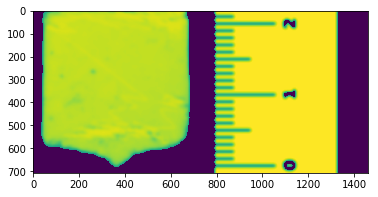

In [5]:
im = cv.imread('CE_22-10s-foam2.jpg')#load image
im_r=cv.rotate(im, cv.ROTATE_90_COUNTERCLOCKWISE)#rotate image (not necessary)
imgray = cv.cvtColor(im_r, cv.COLOR_BGR2GRAY)#convert RGB to grayscale
blur = cv.GaussianBlur(imgray,(41,41), 0)#gaussian blur with kernel size 41*41 pixel
ret, thresh = cv.threshold(blur,135,255,cv.THRESH_TOZERO)#set threshold (135)
r,c=thresh.shape#define r and c as array shape
scale=2.2/r#defime cm/pixel scale by dividing 2.2cm with heigth of image
print(scale)
plt.imshow(thresh)

2


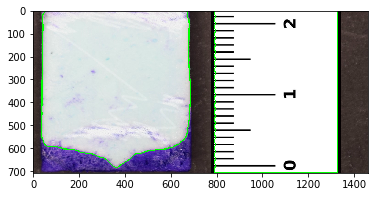

In [6]:
img, contours, hierarchy = cv.findContours(thresh,0, cv.CHAIN_APPROX_NONE)#find contours
print(len(contours))#number of contours
for contour in contours:
    cv.drawContours(im_r, contour, -1, (0, 255, 0), 3)#draw all contours
plt.figure()
plt.imshow(im_r)

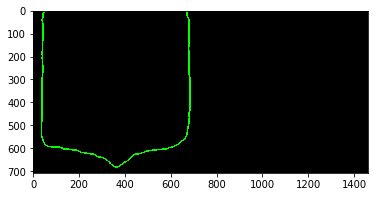

In [7]:
canvas = np.zeros_like(im_r)
cv.drawContours(canvas , contours, 1, (0, 255, 0), 5)#draw desired contour (in this case 1)
plt.imshow(canvas)


In [8]:
flow_p=canvas[:,:,1]#slice 3 D array(708,1461,3) into 2 D array, remains of RGB image
flow_p.shape   


(708, 1461)

31 685 1 682
(682, 654)


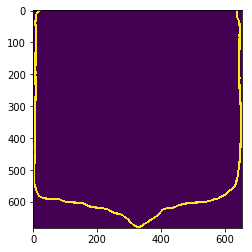

In [9]:
#find largest row value for cropping
num_rows, num_cols = flow_p.shape
flow_p= flow_p[3:num_rows-3,3:num_cols-3]
max_col=0
min_col=num_cols
min_row=1
max_row=0
num_rows, num_cols = flow_p.shape
for i in range(num_rows):
    for j in range(num_cols):
        if flow_p[i][j] == 255:
            if j>max_col:
                max_col=j
            elif j<min_col:
                min_col=j
for i in range(num_rows):
    for j in range(num_cols):
        if flow_p[i][j] == 255:
            if i>max_row:
                max_row=i
            
print(min_col,max_col,min_row,max_row)
flow_p_crop = flow_p[min_row:max_row+1,min_col:max_col]

# Shows the image in image viewer 
print(flow_p_crop.shape)
plt.imshow(flow_p_crop) 


In [10]:
num_rows_c, num_cols_c = flow_p_crop.shape
print(flow_p_crop.shape)
max_value = np.max(flow_p_crop)
print(max_value)

(682, 654)
255


(682, 654)
5.0
0.0


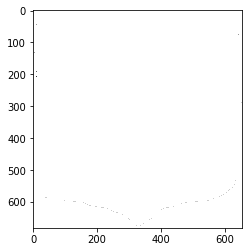

In [11]:
#create empty twin array of image
arr=np.zeros([num_rows_c,num_cols_c])
print(arr.shape)
#create labelled bitmap which count from "top" to "bottom" for every r-coordinat
for j in range(num_cols_c):
        m=0
        for i in range(num_rows_c-1):
            if flow_p_crop[i][j]==255 and flow_p_crop[i-1][j]==0 and flow_p_crop[i+1][j]==255:
                m=m+1
                arr[i][j]=m
#maximal number of counts in one line           
max_value = np.max(arr)
#minimal number of counts in one line  
min_value = np.min(arr)
print(max_value)
print(min_value)           
#flter lines by setting count threshold
count=6
for j in range(num_cols_c):
        for i in range(num_rows_c):
            if arr[i][j] >count:
                   arr[i][j] = 0 

plt.imshow(arr,cmap=cm.binary)

In [12]:
 #find largest row value for cropping
num_rows_c, num_cols_c = arr.shape
max_row=0
for i in range(num_rows_c):
    for j in range(num_cols_c):
        if arr[i][j] >= 1:
            if i>max_row:
                max_row=i
print(max_row)

675


In [13]:
#Define z axis dimensions enter height in cm
h=1.4#height in cm you want
num_rows_c3=round(h/scale)
w=scale*num_cols_c
min_row=max_row-num_rows_c3
#get mincol and max col
num_rows_c, num_cols_c = arr.shape
max_col=0
min_col=num_cols_c
for i in range(num_rows_c):
    for j in range(num_cols_c):
        if arr[i][j] >= 1:
            if j>max_col:
                max_col=j
            elif j<min_col:
                min_col=j
print(min_col,max_col,min_row, max_row)

0 653 224 675


(452, 653)


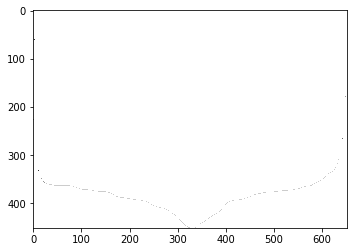

In [14]:
flow_p_crop3 = arr[min_row:max_row+1,min_col:max_col]
print(flow_p_crop3.shape)
plt.imshow(flow_p_crop3,cmap=cm.binary)


In [15]:
num_rows_c3, num_cols_c3 = flow_p_crop3.shape
print(num_rows_c3, num_cols_c3)
h=1.4
#create corresponding cm scales
z1=np.linspace(-h, 0,num=num_rows_c3)
z_axis=np.round(z1,1)
x1=np.linspace(-w/2, w/2,num=num_cols_c3-1)
x_axis=np.round(x1,1)




452 653


In [20]:
import pandas as pd
r_list=[]
z_list=[]
count_list=[]
count=6
#create list for every label in bitmap
for c in range(1,count+1):
    for j in range(num_cols_c3):
            for i in range(num_rows_c3):
                        if flow_p_crop3[i][j] == c:
                            count_list.append(c)
                            z_list.append(i*scale-h) 
                            r_list.append(j*scale-(w/2))
             
dfx1 = pd.DataFrame(r_list, columns =['r-pos,cm']) 
dfx1['z-pos,cm'] = z_list
dfx1['count_list'] = count_list

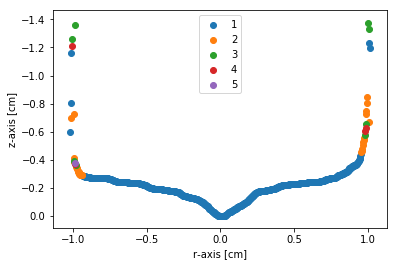

In [21]:
import pandas as pd
dfx1 = pd.DataFrame(r_list, columns =['r-pos,cm']) 
dfx1['z-pos,cm'] = z_list
dfx1['count_list'] = count_list

for name, data in dfx1.groupby('count_list'):
    plt.scatter(data['r-pos,cm'], data['z-pos,cm'], label=name)

plt.gca().invert_yaxis()
plt.xlabel('r-axis [cm]')
plt.ylabel('z-axis [cm]')
plt.legend()
plt.savefig('thresh', dpi=600, bbox_inches='tight')
plt.show()
